# Figure 4: Adversarial Setting

This notebook generates figure 4 from 'Meta-Learning the Inductive Bias of Simple Neural Circuits', Dorrell et al. 2022.

We meta-learn a function that one learner finds easy to learn but another doesn't

This notebook actually contains two experiments. The first is linear vs. kernel, as shown in the paper. The second is making two different kernel learners fight and shows the limits of this approach when the two learners are similar.

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
from scipy import special

/Users/will/opt/anaconda3/envs/inductive_II/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# model parameters
input_size_gen = 3
hidden_size_gen = 150
output_size_gen = 1

K=20

J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
J = torch.from_numpy(J).float()

# Neural Network

layers = 2

class NeuralNet(nn.Module):
    def __init__(self,input_size_gen,hidden_size_gen, output_size_gen):
        super(NeuralNet,self).__init__()
        self.linear1 = nn.Linear(input_size_gen,hidden_size_gen, bias = True)
        self.linearh = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size_gen,output_size_gen, bias = True)

    def forward(self, x):
        out = self.linear1(x)
        for i in range(layers-1):
            out = self.relu(out)
            out = self.linearh(out)
        #out = self.relu(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out

class NeuralNetFly(nn.Module):
  def __init__(self, input_size_gen, K, output_size_gen):
    super(NeuralNetFly,self).__init__()
    self.linear1 = nn.Linear(input_size_gen, K, bias=True)
    self.linear2 = nn.Linear(K, output_size_gen, bias=True)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu(out)
    out = self.linear2(out)
    return out

In [3]:
# Function to generate N datapoints on the sphere
def new_data(N):
  x = torch.normal(0,1,[N,3])
  return x/torch.norm(x, dim = 1)[:,np.newaxis]

# Function to map points on sphere to 2D
def threeto2D(x):
  y = np.zeros([x.shape[0], 2])
  y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
  y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
  return y

# plots to see whether the function is learning 
def plotty_dotty(Losses, y, fly_label, z_init, z):
  # Plot the loss and the classifications
  plt.figure(figsize = (8,8))
  print(f"loss fly: {((fly_label-z)**2).mean()}")
  #colors = np.array([a * colorRight + (1 - a) * colorLeft for a in scaled], dtype = np.int64)
  #sc.scatter(np.arange(len(fly_label)), fly_label, c = colors/255)
  # Plot losses
  plt.subplot(2,2,1)
  plt.plot(Losses)
  plt.title('Loss')

  # Plot the two classifications
  plt.subplot(2,2,2)
  plt.scatter(y[:,0], y[:,1], c = fly_label)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Fly Labelling')

  plt.subplot(2,2,3)
  plt.scatter(y[:,0], y[:,1], c = z_init)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Initial Network Labelling')

  plt.subplot(2,2,4)
  plt.scatter(y[:,0], y[:,1], c = z)
  plt.colorbar()
  #plt.clim(-1,1) 
  plt.title('Final Network Labelling')

# plots to see whether the function is learning 
def plotty_comp(Losses, y, fly1, fly2, z):
  # Plot the loss and the classifications
  plt.figure(figsize = (8,8))
  print(f"loss 1: {((fly1-z)**2).mean()}")
  print(f"loss 1: {((fly2-z)**2).mean()}")
  #colors = np.array([a * colorRight + (1 - a) * colorLeft for a in scaled], dtype = np.int64)
  #sc.scatter(np.arange(len(fly_label)), fly_label, c = colors/255)
  # Plot losses
  plt.subplot(2,2,1)
  plt.plot(Losses)
  plt.title('Loss')

  # Plot the two classifications
  plt.subplot(2,2,2)
  plt.scatter(y[:,0], y[:,1], c = fly1)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Fly Labelling A')

  plt.subplot(2,2,3)
  plt.scatter(y[:,0], y[:,1], c = fly2)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Fly Labelling B')

  plt.subplot(2,2,4)
  plt.scatter(y[:,0], y[:,1], c = z)
  plt.colorbar()
  plt.clim(-1,1) 
  plt.title('Final Network Labelling')

## Ridge regression vs kernel regression

In [4]:
K = 20

#J sampled from normal distribution vs J learnt

# J random
J1 = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
J1 = torch.from_numpy(J1).float()

def loss_fight(x_tr, x_te, z_tr, z_te, distr, J1):
  '''
  z - model's label
  fly_label_lin_reg - linear regression with formula 
  fly_label_ker_reg - J sampled from normal distribution
  '''
  y1_tr = torch.nn.functional.relu(torch.matmul(x_tr,J1))
  y1_te = torch.nn.functional.relu(torch.matmul(x_te,J1))
  w1 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y1_tr,0,1), y1_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y1_tr,0,1), z_tr))
  w2 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x_tr,0,1), x_tr) + 0.001*torch.eye(3)),torch.matmul(torch.transpose(x_tr,0,1), z_tr))
  fly_label_ker_reg = torch.matmul(y1_te, w1)
  fly_label_lin_reg = torch.matmul(x_te, w2)

  loss_entropy = SamplesLoss(loss="sinkhorn", p=2, blur=.05) 
  loss_fly = torch.mean((fly_label_ker_reg-z_te)**2) - torch.mean((fly_label_lin_reg-z_te)**2)
  
  return 30*loss_entropy(z_tr, distr) + 30*loss_entropy(z_te, distr) + loss_fly

def fly_label_fixed(x, J1, z):
  '''
  z - model's label
  fly_label_lin_reg - linear regression with formula 
  fly_label_ker_reg - J sampled from normal distribution
  '''
  y1 = torch.nn.functional.relu(torch.matmul(x,J1))
  w1 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y1,0,1), y1) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y1,0,1), z))
  w2 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x,0,1), x) + 0.001*torch.eye(3)),torch.matmul(torch.transpose(x,0,1), z))
  fly_label_ker_reg = torch.matmul(y1, w1)
  fly_label_lin_reg = torch.matmul(x, w2)
  return fly_label_ker_reg, fly_label_lin_reg

loss fly: 0.006871948018670082
loss fly: 0.10423952341079712


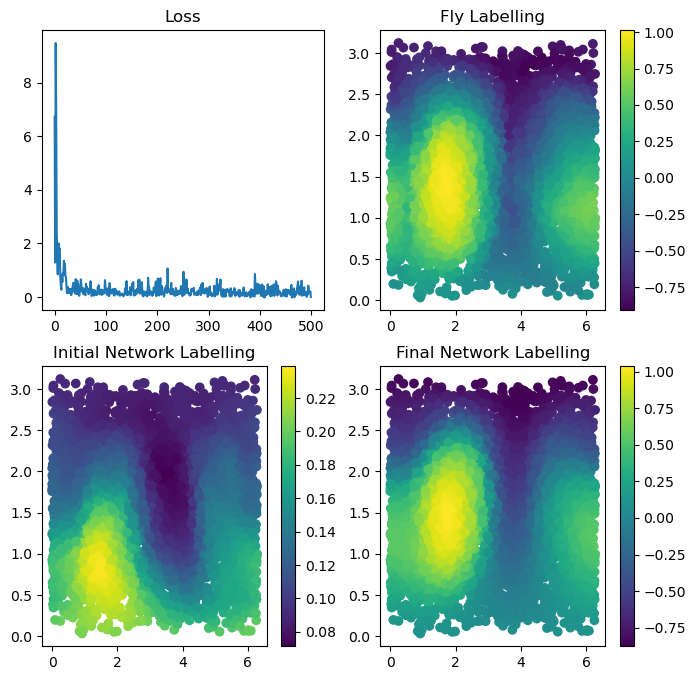

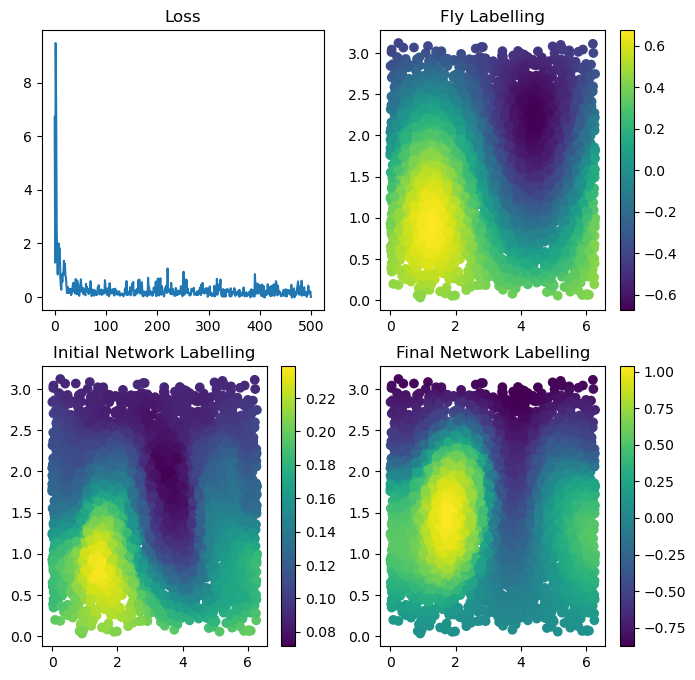

In [5]:
# Set up optimiser and loss
model = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Parameter choices
M = 200 # Number of datapoints for each training step
T = 500 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model(x_plot).detach().numpy()

# normal distribution
#distr = torch.normal(0, 1, [300,1])
distr = 2 * torch.rand(M//2, 1) - 1

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//4)
  x_te = new_data(M//4*3)
  z_tr = model(x_tr)
  z_te = model(x_te)
  loss = loss_fight(x_tr, x_te, z_tr, z_te, distr, J1)
  #print(f"Loss {step}: {loss}")
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model(x_plot).detach()
fly_label_ker, fly_label_lin = fly_label_fixed(x_plot, J1, z)
z = z.numpy()
fly_label_ker = fly_label_ker.numpy()
fly_label_lin = fly_label_lin.numpy()
y = threeto2D(x_plot.detach().numpy())

plotty_dotty(Losses, y, fly_label_ker, z_init, z)
plotty_dotty(Losses, y, fly_label_lin, z_init, z)

loss 1: 0.006871948018670082
loss 1: 0.10423952341079712


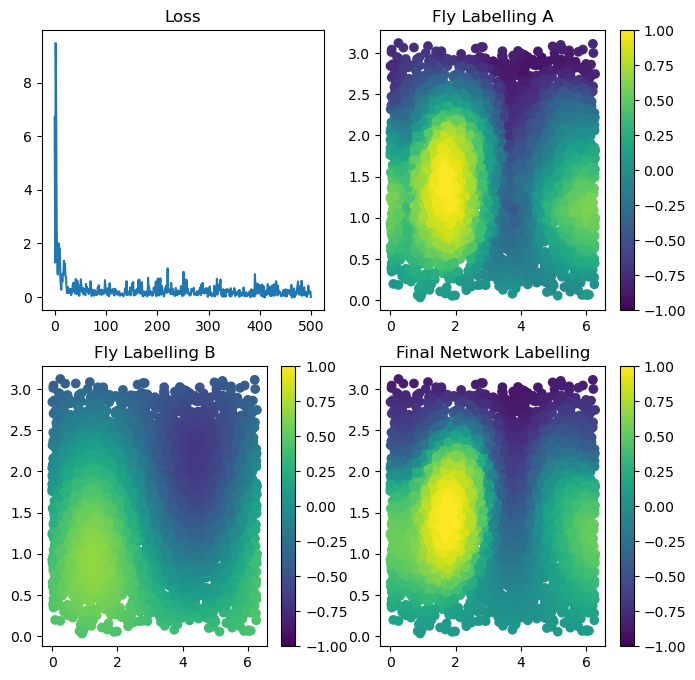

In [6]:
plotty_comp(Losses, threeto2D(x_plot), fly_label_ker, fly_label_lin, z)

In [7]:
M_plot = 5000
x_plot = new_data(M_plot)
z = model(x_plot).detach()
fly_label_ker, fly_label_lin = fly_label_fixed(x_plot, J1, z)
fly_label_ker = fly_label_ker.numpy()
fly_label_lin = fly_label_lin.numpy()
z = z.numpy()
MSE_1 = np.sum((fly_label_ker - z)**2)/(2*M_plot)

MSE_2 = np.sum((fly_label_lin - z)**2)/(2*M_plot)

print(MSE_1)
print(MSE_2)

0.0035960189819335938
0.05165111083984375


## Kernel A vs Kernel B

In [8]:
K = 20
# J1 random
J1 = torch.from_numpy(np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))).float()

# J2 structured
c = 10
J2 = torch.from_numpy(np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))).float()


In [9]:
def loss_fight(x_tr, x_te, z_tr, z_te, distr, J1, J2):
  '''
  z_tr, z_te - model's label
  fly_label_ker_reg_1 - kernel regression with J random
  fly_label_ker_reg_2 - kernel regression with J biased
  '''
  y1_tr = torch.nn.functional.relu(torch.matmul(x_tr,J1))
  y1_te = torch.nn.functional.relu(torch.matmul(x_te,J1))

  y2_tr = torch.nn.functional.relu(torch.matmul(x_tr,J2))
  y2_te = torch.nn.functional.relu(torch.matmul(x_te,J2))

  w1 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y1_tr,0,1), y1_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y1_tr,0,1), z_tr))
  w2 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y2_tr,0,1), y2_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y2_tr,0,1), z_tr))
  fly_label_ker_reg_1 = torch.matmul(y1_te, w1)
  fly_label_ker_reg_2 = torch.matmul(y2_te, w2)

  loss_entropy = SamplesLoss(loss="sinkhorn", p=2, blur=.05) 
  loss_fly = -torch.mean((fly_label_ker_reg_1-z_te)**2) + torch.mean((fly_label_ker_reg_2-z_te)**2)
  
  return 30*loss_entropy(z_tr, distr) + 30*loss_entropy(z_te, distr) + loss_fly

def fly_label_fixed(x, J1, J2, z):
  '''
  z_tr, z_te  - model's label
  fly_label_ker_reg_1 - kernel regression with J random
  fly_label_ker_reg_2 - kernel regression with J biased
  '''
  y1 = torch.nn.functional.relu(torch.matmul(x,J1))
  y2 = torch.nn.functional.relu(torch.matmul(x,J2))

  w1 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y1,0,1), y1) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y1,0,1), z))
  w2 = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y2,0,1), y2) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y2,0,1), z))
  fly_label_ker_reg_1 = torch.matmul(y1, w1)
  fly_label_ker_reg_2 = torch.matmul(y2, w2)
  return fly_label_ker_reg_1, fly_label_ker_reg_2

Loss 0: 8.847949028015137
Loss 1: 1.5483492612838745
Loss 2: 4.996856212615967
Loss 3: 1.7599257230758667
Loss 4: 4.510157585144043
Loss 5: 1.0299019813537598
Loss 6: 0.9925363063812256
Loss 7: 1.4131824970245361
Loss 8: 3.003957748413086
Loss 9: 1.6010664701461792
Loss 10: 1.080440878868103
Loss 11: 0.38131219148635864
Loss 12: 0.7333776950836182
Loss 13: 0.6471418142318726
Loss 14: 1.6359444856643677
Loss 15: 0.6938682198524475
Loss 16: 0.6402850151062012
Loss 17: 1.2023038864135742
Loss 18: 0.21308445930480957
Loss 19: 0.18982523679733276
Loss 20: 0.3040097951889038
Loss 21: 0.3321766257286072
Loss 22: 0.30175846815109253
Loss 23: 0.3782460689544678
Loss 24: 0.41075217723846436
Loss 25: 0.4023878276348114
Loss 26: 0.349932461977005
Loss 27: 0.6971697807312012
Loss 28: 0.3517388701438904
Loss 29: 0.15112438797950745
Loss 30: 0.37578463554382324
Loss 31: 0.5908942818641663
Loss 32: 0.3393615186214447
Loss 33: 0.24530892074108124
Loss 34: 0.37898436188697815
Loss 35: 0.2682826817035675

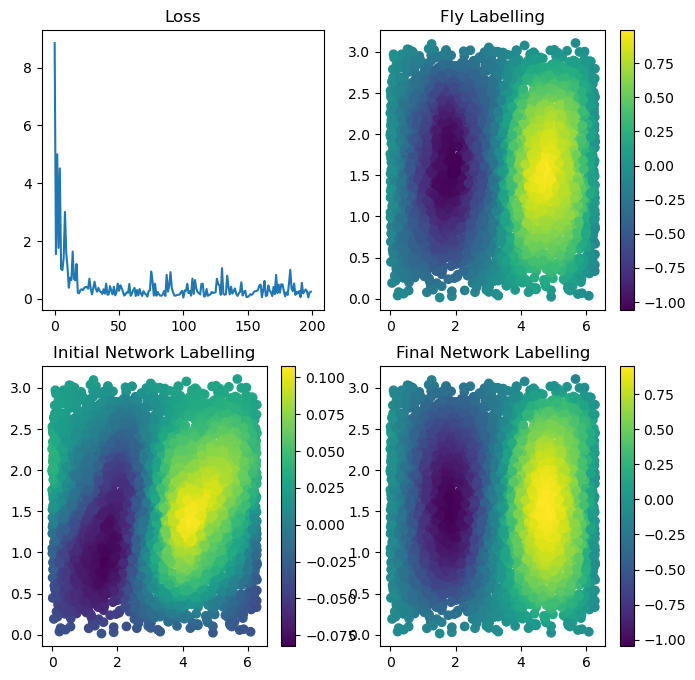

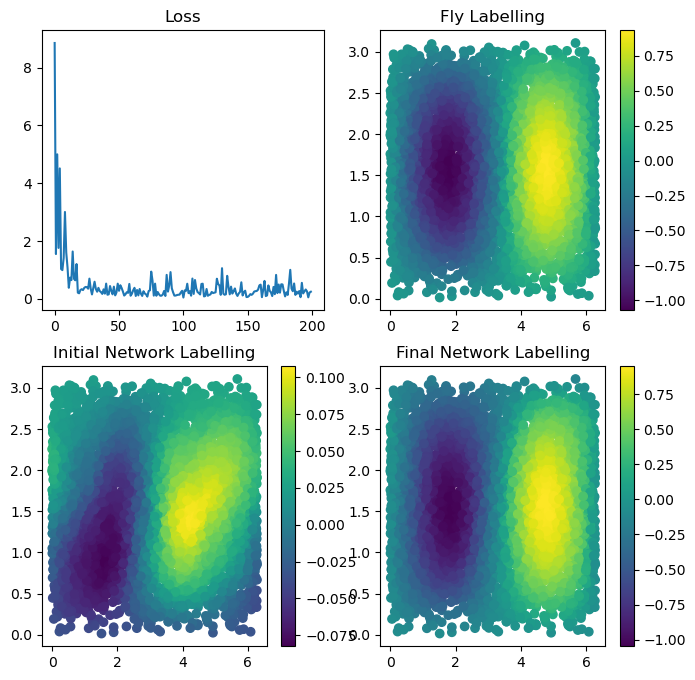

In [10]:
# Set up optimiser and loss
model = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Parameter choices
M = 200 # Number of datapoints for each training step
T = 200 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model(x_plot).detach().numpy()

# normal distribution
#distr = torch.normal(0, 1, [300,1])
distr = 2 * torch.rand(M//2, 1) - 1

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//4)
  x_te = new_data(M//4*3)
  z_tr = model(x_tr)
  z_te = model(x_te)
  # J1 random
  J1 = torch.from_numpy(np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))).float()
  # J2 structured
  c = 0
  J2 = torch.from_numpy(np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))).float()
  loss = loss_fight(x_tr, x_te, z_tr, z_te, distr, J1, J2)
  print(f"Loss {step}: {loss}")
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model(x_plot).detach()
fly_label1, fly_label2 = fly_label_fixed(x_plot, J1, J2, z)
z = z.numpy()
fly_label1 = fly_label1.numpy()
fly_label2 = fly_label2.numpy()
y = threeto2D(x_plot.detach().numpy())

plotty_dotty(Losses, y, fly_label1, z_init, z)
plotty_dotty(Losses, y, fly_label2, z_init, z)